In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 目的：スペインの電力価格を予測
# 目的変数：スペインの電力価格(actual_price)
# 評価指標：RME

import numpy as np
import pandas as pd
import os
import pickle
import gc
# 分布確認
!pip install ydata-profiling
from ydata_profiling import ProfileReport
# 可視化
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelEncoder,OneHotEncoder
# モデリング
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
import lightgbm as lgb
# 日本語表記
!pip install japanize-matplotlib
import japanize_matplotlib
%matplotlib inline
# パラメータ最適化
!pip install optuna
import optuna

# 評価指標
from sklearn.metrics import mean_squared_error

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.5 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=6ff830127374f97ff4819e43f4db6dd6e9c587911a58f584e5a48003e1614250
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 38.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=c81eff653b67c0efb5aabc59b56be44fe2dbaf0b81a4c340ce4ce22fbe35b12c
  Stored in directory: /root/.cache/pip/wheels/da/a1/71/b8faeb93276fed10edffcca20746f1ef6f8d9e071eee8425fc
Successfully built japanize-matplotlib
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 20.3 MB/s eta 0:00:00


In [3]:
file_path = '/content/drive/MyDrive/Colab Notebooks/signate/smbc/'

df_train = pd.read_csv(file_path + 'train.csv')
df_test = pd.read_csv(file_path + 'test.csv')
df_sample = pd.read_csv(file_path + 'sample_submit.csv',header=None)

In [ ]:
print(df_train.shape)
display(df_train.head())
display(df_train.info())

In [ ]:
print(df_test.shape)
display(df_test.head())
display(df_test.info())

In [4]:
# 時刻をdatetimeに変換
df_train["time"] = pd.to_datetime(df_train["time"],utc=True)
df_test["time"] = pd.to_datetime(df_test["time"],utc=True)

# 年情報のカラム作成（クロスバリデーション用）
df_train["year"] = df_train["time"].dt.year
df_test["year"] = df_test["time"].dt.year

# ケルビンを摂氏に変換  - 273.15
cities = ["valencia","madrid","bilbao","barcelona","seville"]
for city in cities:
  df_train[f"{city}_temp"] = df_train[f"{city}_temp"] - 273.15
  df_train[f"{city}_temp_min"] = df_train[f"{city}_temp_min"] - 273.15
  df_train[f"{city}_temp_max"] = df_train[f"{city}_temp_max"] - 273.15




## 特徴量エンジニアリング

In [5]:
# 季節性（spring:1,summer:2,autumn:3,winter:4）
def get_season(month):
    if month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    elif month in [9, 10, 11]:
        return 3
    else:
        return 4

# 月を取得 → 季節に変換
df_train["month"] = df_train["time"].dt.month
df_train["season"] = df_train["month"].apply(get_season)

# テストデータにも
df_test["month"] = df_test["time"].dt.month
df_test["season"] = df_test["month"].apply(get_season)

In [6]:
# 時間帯（morning:1,afternoon:2,evening:3,night:4）

def get_time_of_day(hour):
    if 5 <= hour < 11:
        return 1
    elif 11 <= hour < 17:
        return 2
    elif 17 <= hour < 21:
        return 3
    else:
        return 4

df_train["hour"] = df_train["time"].dt.hour
df_train["time_of_day"] = df_train["hour"].apply(get_time_of_day)

# テストデータにも
df_test["hour"] = df_test["time"].dt.hour
df_test["time_of_day"] = df_test["hour"].apply(get_time_of_day)

In [7]:
# 週末フラグ

def is_week_end(weekday):
    if weekday in [0,1,2,3,4]:
      return 0
    elif weekday in [5,6]:
      return 1
    else:
      return 2

df_train["weekday"] = df_train["time"].dt.weekday
df_train["is_weekend"] = df_train["weekday"].apply(is_week_end)

# テストデータにも
df_test["weekday"] = df_test["time"].dt.weekday
df_test["is_weekend"] = df_test["weekday"].apply(is_week_end)

In [8]:
# 発電量の和
generation_columns = [col for col in df_train.columns if 'generation' in col]
df_train['generation_sum'] = df_train[generation_columns].sum(axis=1)
df_test['generation_sum'] = df_test[generation_columns].sum(axis=1)

In [9]:
# 発電量のうちの火力発電の構成比[fossil]再生可能エネルギー構成比[renewable]
df_train['generation_sum'] = df_train[generation_columns].sum(axis=1)
df_test['generation_sum'] = df_test[generation_columns].sum(axis=1)

# --- ② 分子になる電源グループ ---
df_train["fossil_total"]     = (
        df_train["generation_fossil_gas"]
      + df_train["generation_fossil_hard_coal"]
      + df_train["generation_fossil_oil"]
)
df_test["fossil_total"]      = (
        df_test["generation_fossil_gas"]
      + df_test["generation_fossil_hard_coal"]
      + df_test["generation_fossil_oil"]
)

df_train["renewable_total"]  = (
        df_train["generation_hydro_pumped_storage_consumption"]
      + df_train["generation_hydro_run_of_river_and_poundage"]
      + df_train["generation_hydro_water_reservoir"]
      + df_train["generation_other_renewable"]
)
df_test["renewable_total"]   = (
        df_test["generation_hydro_pumped_storage_consumption"]
      + df_test["generation_hydro_run_of_river_and_poundage"]
      + df_test["generation_hydro_water_reservoir"]
      + df_test["generation_other_renewable"]
)

# --- ③ 比率を安全に計算（0 除算防止） ---
eps = 1e-6
df_train["fossil_share"]     = df_train["fossil_total"]    / (df_train["generation_sum"] + eps)
df_test["fossil_share"]      = df_test["fossil_total"]     / (df_test["generation_sum"]  + eps)

df_train["renewable_share"]  = df_train["renewable_total"] / (df_train["generation_sum"] + eps)
df_test["renewable_share"]   = df_test["renewable_total"]  / (df_test["generation_sum"]  + eps)

## データ分割＆モデル実装

In [10]:
# カテゴリカルカラムの抜き出し
categorical_cols = [
    col for col in df_train.select_dtypes(include=['object', 'category']).columns
    if col != "price_actual"
    ]
# 数値カラムの抜き出し
numerical_cols = [
    col for col in df_train.select_dtypes(include=['int64', 'float64']).columns
    ]
print('*'*20,'実行結果確認','*'*20,)
print(f'カテゴリ{categorical_cols}')
print(f'数値{numerical_cols}')

******************** 実行結果確認 ********************
カテゴリ['valencia_weather_main', 'valencia_weather_description', 'valencia_weather_icon', 'madrid_weather_main', 'madrid_weather_description', 'madrid_weather_icon', 'bilbao_weather_main', 'bilbao_weather_description', 'bilbao_weather_icon', 'barcelona_weather_main', 'barcelona_weather_description', 'barcelona_weather_icon', 'seville_weather_main', 'seville_weather_description', 'seville_weather_icon']
数値['generation_biomass', 'generation_fossil_brown_coal/lignite', 'generation_fossil_gas', 'generation_fossil_hard_coal', 'generation_fossil_oil', 'generation_hydro_pumped_storage_consumption', 'generation_hydro_run_of_river_and_poundage', 'generation_hydro_water_reservoir', 'generation_nuclear', 'generation_other', 'generation_other_renewable', 'generation_solar', 'generation_waste', 'generation_wind_onshore', 'total_load_actual', 'valencia_temp', 'valencia_temp_min', 'valencia_temp_max', 'valencia_pressure', 'valencia_humidity', 'valencia_wi

In [35]:
# 特徴量の整理

base_features = [
    'generation_fossil_gas',
    'generation_fossil_hard_coal',
    'generation_fossil_oil',
    'generation_hydro_pumped_storage_consumption',
    'generation_hydro_run_of_river_and_poundage',
    'generation_hydro_water_reservoir',
    'generation_other_renewable',
    'total_load_actual',
    "season",
    "time_of_day",
    "is_weekend",
    #'generation_sum',
    "fossil_share",
    "renewable_share"
]
add_features = []

# 目的変数のSeries作成
y_train = df_train["price_actual"]

In [40]:
# モデルの関数化

''' LightGBMモデルの関数
    LightGBM を Q4（2017-10-01〜12-31）のみで検証し、
    seed を変えて 5 回学習 → 予測を平均して安定化する版
  arg:
    -------
    input_x:trainデータの説明変数
    input_y:trainデータの目的変数
    input_test:testデータ
    base_features:基本の特徴量のリスト
    add_features:追加したい特徴量のリスト
    params:LightGBMのパラメータ。辞書型を想定
    -------
  return:
    -------
    oof : np.ndarray
        検証行(Q4)にだけ予測値が入り、それ以外は 0
    test_pred : np.ndarray
        test データの予測値（seed 平均）
    rmse_list : list
        seed ごとの RMSE
    feature_importance : pd.DataFrame
        最終 seed モデルの split / gain 重要度
    """
  '''

def light_gbm_model(input_x,input_y,input_test,base_features,add_features,params):

  TARGET = "price_actual"  # input_y の列名（必要なら書き換え）
  DATE   = "time"          # 日時列（datetime64 型）

  # 特徴量の作成
  features = base_features + add_features

  # 検証は17年Q4だけ
  val_mask   = input_x[DATE].between("2017-10-01", "2017-12-31")

  # それ以外を学習
  train_mask = ~val_mask

  # oof:out of fold/テスト結果格納/スコアリスト
  SEEDS = [0, 1, 2, 3, 4]                    # 好きな整数 5 個
  oof        = np.zeros(len(input_x))
  val_pred  = np.zeros(val_mask.sum())       # 検証用の平均予測
  test_pred = np.zeros(len(input_test))      # テスト用の平均予測
  rmse_list = []

  for i, s in enumerate(SEEDS):
    print("#" * 15, f"Fold {i+1}（SEEDS: {s}）", "#" * 15)

    # 訓練、検証用のデータセット
    x_tr, y_tr = input_x.loc[train_mask, features],input_y.loc[train_mask]
    x_va, y_va = input_x.loc[val_mask, features],input_y.loc[val_mask]

    # モデルを訓練する
    lgb_model = lgb.LGBMRegressor(**params)
    lgb_model.fit(
        x_tr, y_tr,
        eval_set=[(x_va, y_va)],
        eval_metric="rmse",
        callbacks=[
          lgb.early_stopping(stopping_rounds=100),
          lgb.log_evaluation(period=10) # verboseの設定
          ]
      )
    # 検証用データに対する予測を書き込む
    y_pred = lgb_model.predict(x_va)
    val_pred += y_pred / len(SEEDS)

    # テスト予測も加算
    test_pred += lgb_model.predict(input_test[features]) / len(SEEDS)


    # RMSE を計算（squared=False で平方根を取る）
    mse = mean_squared_error(y_va, y_pred)
    rmse = np.sqrt(mse)
    rmse_list.append(rmse)
    print(f"RMSE: {rmse:.4f}")

 # ------------------ oof と importance ------------------
  oof[val_mask] = val_pred

  # 特徴量名とimportanceを取得
  feature_importance = pd.DataFrame({
      'feature': x_tr.columns,
      'importance': lgb_model.feature_importances_,  # splitの数
      'gain': lgb_model.booster_.feature_importance(importance_type='gain')  # gain値
  })


  return oof,test_pred,rmse_list,feature_importance

In [60]:
# ─────────────────────────────────────────────
# 1. 2017 年 Q1〜Q4 を順番にバリデーションにする分割関数
# ─────────────────────────────────────────────
def walk_forward_quarter_splits(df, date_col="time"):
    """17年をQごとに4分割し、常に『過去だけ』で学習させる"""
    quarter_end = {
        1: "2017-03-31",
        2: "2017-06-30",
        3: "2017-09-30",
        4: "2017-12-31",
    }
    splits = []
    for q in [1, 2, 3, 4]:
        val_idx = df[(df[date_col].dt.year == 2017) &
                     (df[date_col].dt.quarter == q)].index
        # train は「検証Q より前」だけ
        train_idx = df[df[date_col] <= quarter_end[q-1] if q > 1 else
                       df[date_col] < "2017-01-01"].index
        splits.append((train_idx, val_idx))
    return splits

# ─────────────────────────────────────────────
# 2. モデル学習・推論関数（改訂版）
# ─────────────────────────────────────────────
def light_gbm_model_v2(
        input_x, input_y, input_test,
        base_features, add_features,
        params,
        date_col="time",
        seeds=(0, 1, 2, 3, 4)
    ):
    """
    - 2017 年 Q1〜Q4 を 4 fold で検証
    - 各 fold 内で seed を変えて 5 回学習し予測を平均
    """

    import numpy as np
    import pandas as pd
    import lightgbm as lgb
    from sklearn.metrics import mean_squared_error

    # --- 特徴量リスト（time 列は除く） -----------------
    features = base_features+add_features

    # --- 出力用器 --------------------------------------
    oof   = np.zeros(len(input_x))
    preds = np.zeros(len(input_test))
    rmse_list = []

    # --- 4 fold を取得 ---------------------------------
    cv_splits = walk_forward_quarter_splits(input_x, date_col=date_col)

    # --------------- fold ループ ------------------------
    for fold, (train_idx, val_idx) in enumerate(cv_splits, 1):
        print(f"\n╭─── Fold {fold}  ({input_x.loc[val_idx, date_col].dt.quarter.iloc[0]}Q) ───╮")

        x_tr, y_tr = input_x.loc[train_idx, features], input_y.loc[train_idx]
        x_va, y_va = input_x.loc[val_idx,   features], input_y.loc[val_idx]

        # fold ごとの予測格納器
        va_pred_fold  = np.zeros(len(val_idx))
        test_pred_fold = np.zeros(len(input_test))

        # -------- seed ループ ---------------------------
        for s in seeds:
            model = lgb.LGBMRegressor(random_state=s, **params)
            model.fit(
                x_tr, y_tr,
                eval_set=[(x_va, y_va)],
                eval_metric="rmse",
                callbacks=[
                  lgb.early_stopping(stopping_rounds=100),
                  lgb.log_evaluation(period=10) # verboseの設定
                  ]
              )

            va_pred_fold  += model.predict(x_va)              / len(seeds)
            test_pred_fold += model.predict(input_test[features]) / len(seeds)

        # fold ごとの RMSE
        mse  = mean_squared_error(y_va, va_pred_fold)   # ← squared を付けない
        rmse = np.sqrt(mse)                       # √ を自分で取る
        rmse_list.append(rmse)
        print(f"│  fold RMSE : {rmse:.4f}")

        # oof & テスト予測を加算
        oof[val_idx] = va_pred_fold
        preds       += test_pred_fold / len(cv_splits)

    # --- 特徴量重要度（最後のモデル基準だがほぼ同じ） ---
    feature_importance = pd.DataFrame({
        "feature"  : features,
        "split_imp": model.feature_importances_,
        "gain" : model.booster_.feature_importance(importance_type="gain")
    })

    print(f"\n★ 4-fold 平均 RMSE: {np.mean(rmse_list):.4f}")

    return oof, preds, rmse_list, feature_importance


In [61]:
# パラメータ
params = {
    'boosting_type':'gbdt',
    'objective':'regression',
    'metric':'rmse',
    'learning_rate':0.05,
    'num_leaves':64,
    'max_depth':-1,
    'n_estimators':15000,
    'importance_type':'gain'
}


╭─── Fold 1  (1Q) ───╮
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2363
[LightGBM] [Info] Number of data points in the train set: 17521, number of used features: 13
[LightGBM] [Info] Start training from score 54.379606
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 17.1881
[20]	valid_0's rmse: 16.0916
[30]	valid_0's rmse: 15.6152
[40]	valid_0's rmse: 15.6437
[50]	valid_0's rmse: 15.7731
[60]	valid_0's rmse: 15.7973
[70]	valid_0's rmse: 15.8105
[80]	valid_0's rmse: 15.8699
[90]	valid_0's rmse: 15.9094
[100]	valid_0's rmse: 15.9571
[110]	valid_0's rmse: 15.9952
[120]	valid_0's rmse: 15.9978
[130]	valid_0's rmse: 16.0284
Early stopping, best iteration is:
[37]	valid_0's rmse: 15.5629
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the 

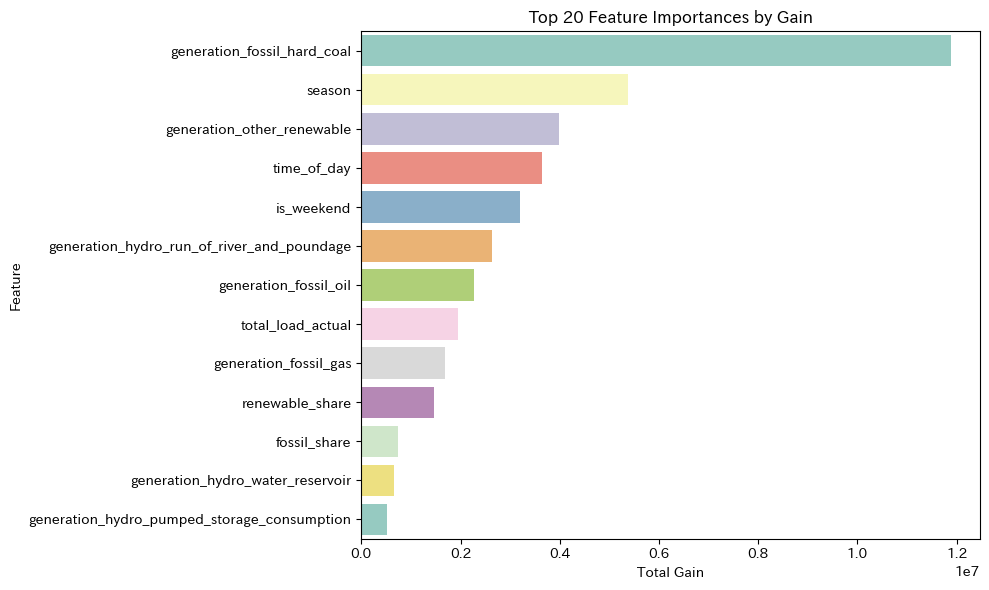

In [62]:
# 関数の実行
#oof, preds, rmse_list,feature_importance = light_gbm_model(df_train,y_train,x_test,base_features,add_features,params)

oof, preds, rmse_list,feature_importance = light_gbm_model_v2(df_train,y_train,x_test,base_features,add_features,params)

print("-"*50,"✅結果まとめ✅","-"*50,)

print(f'平均 RMSE: {np.mean(rmse_list):.4f}')
print(f'OOF array shape: {oof.shape}')
print(f'Preds array shape: {preds.shape}')

# ソート
feature_importance = feature_importance.sort_values('gain', ascending=False)

# 上位20個をプロット
plt.figure(figsize=(10, 6))
sns.barplot(
    x='gain',
    y='feature',
    hue='feature',
    data=feature_importance.head(20),
    palette='Set3',
    legend=False
    )
plt.title("Top 20 Feature Importances by Gain")
plt.xlabel("Total Gain")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [63]:
from datetime import datetime, timedelta, timezone
from zoneinfo import ZoneInfo   # 3.9 から標準搭載

# ① まずは “現在の UTC 時刻” を取得
utc_now = datetime.now(timezone.utc)

# ② UTC → JST(+9) に変換して、日付部分だけ取り出す
today = utc_now.astimezone(ZoneInfo("Asia/Tokyo")).date()

df_sub = pd.read_csv(file_path + 'sample_submit.csv',header=None)

submission = pd.DataFrame({
    'time':df_sub.iloc[:, 0] ,
    'pred': preds
})
submission.to_csv(f'submission_{today}.csv', index=False, header=False)
print(f'✅ Submission file saved as submission_{today}.csv')

✅ Submission file saved as submission_2025-06-16.csv
